# Modeling for Snow Depth Prediction

This notebook is focused on preparing the data for modeling, addressing multicollinearity, and creating training, validation, and testing sets. We will proceed with the following steps:
- Loading the Processed Data
- Creating Lag Features and Derived Variables
- Handling Multicollinearity
- Splitting the Data into Training, Validation, and Testing Sets

### 1. Loading Libraries and Processed Data

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


### 2. Load Processed Data

In [2]:
# Adjust the path based on your current working directory
data_path = os.path.join('..', 'data', 'processed', 'processed_data_for_modeling.csv')

# Load the combined processed data
model_data = pd.read_csv(data_path)

# Ensure 'date' column is in datetime format
model_data['date'] = pd.to_datetime(model_data['date'])

# Display the shape to confirm loading
print(f"Loaded combined data with shape {model_data.shape}")

Loaded combined data with shape (57862, 12)


### 3. Initiating the "Resort" feauture

The data now includes the "resort" feature, we need to handle it appropriately for modeling.  Since 'resort' is a categorical variable, we need to encode it into numerical format using One-Hot encoding.  Furthermore, we'll avoid multicollinearity by dropping one of the dummy variables.

In [3]:
# One-Hot Encode the 'resort' feature
model_data = pd.get_dummies(model_data, columns=['resort'], drop_first=True)

# Display the columns to confirm encoding
print(f"Columns after encoding: {model_data.columns.tolist()}")

Columns after encoding: ['date', 'temperature_min', 'temperature_max', 'precipitation_sum', 'snow_depth', 'season_id', 'is_operating_season', 'snow_depth_lag1', 'snow_depth_lag7', 'temperature_avg', 'temperature_avg_squared', 'resort_cortina_d_ampezzo', 'resort_kitzbuhel', 'resort_kranjska_gora', 'resort_krvavec', 'resort_les_trois_vallees', 'resort_mariborsko_pohorje', 'resort_sestriere', 'resort_solden', 'resort_st_anton', 'resort_st_moritz', 'resort_val_d_isere_tignes', 'resort_val_gardena', 'resort_verbier']


### 4. Preparing Features and Target Variable

Features defined include: 
- temperature_avg
- temperature_avg_squared
- precipitation_sum
- snow_depth_lag1
- snow_depth_lag7
- encoded resort

Defining the target variable - snow_depth

In [4]:
data_operating = model_data[model_data['is_operating_season'] == True].reset_index(drop=True)

print(f"Data shape after filtering for operating season: {data_operating.shape}")

# Define the target variable
y = data_operating['snow_depth']

# Exclude 'date' and 'snow_depth' from features
feature_columns = [col for col in data_operating.columns if col not in ['date', 'snow_depth']]

# Create the features DataFrame
X = data_operating[feature_columns]

Data shape after filtering for operating season: (39668, 24)


#### 5. Check for Non-Numeric Columns & Handle "season_id"

Ensure any columns in x that are of data types, object or bool.  Non numeric values need to be handled before modeling.  Subsequently perform one-hot encoding to convert season_id into numeric dummy variables.

In [5]:
# Check for non-numeric columns
non_numeric_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
print(f"Non-numeric columns before processing: {non_numeric_cols}")

# Handle 'season_id' column
# One-Hot Encode 'season_id' if it's in the features
if 'season_id' in X.columns:
    # One-Hot Encode 'season_id'
    season_dummies = pd.get_dummies(X['season_id'], prefix='season', drop_first=True)
    # Drop 'season_id' and add the encoded variables
    X = pd.concat([X.drop(columns=['season_id']), season_dummies], axis=1)

# Convert boolean columns to integers
bool_columns = X.select_dtypes(include=['bool']).columns.tolist()
if bool_columns:
    X[bool_columns] = X[bool_columns].astype(int)

# Verify all columns are now numeric
non_numeric_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns after processing: {non_numeric_cols}")
print("Data types after processing:")
print(X.dtypes)

Non-numeric columns before processing: ['season_id', 'is_operating_season', 'resort_cortina_d_ampezzo', 'resort_kitzbuhel', 'resort_kranjska_gora', 'resort_krvavec', 'resort_les_trois_vallees', 'resort_mariborsko_pohorje', 'resort_sestriere', 'resort_solden', 'resort_st_anton', 'resort_st_moritz', 'resort_val_d_isere_tignes', 'resort_val_gardena', 'resort_verbier']
Non-numeric columns after processing: []
Data types after processing:
temperature_min              float64
temperature_max              float64
precipitation_sum            float64
is_operating_season            int64
snow_depth_lag1              float64
snow_depth_lag7              float64
temperature_avg              float64
temperature_avg_squared      float64
resort_cortina_d_ampezzo       int64
resort_kitzbuhel               int64
resort_kranjska_gora           int64
resort_krvavec                 int64
resort_les_trois_vallees       int64
resort_mariborsko_pohorje      int64
resort_sestriere               int64
resort_

### 5. Handling Multicollinearity

Before splitting the data, it's important to check for multicollinearity among features.

Calculating the Variance Inflation Factor (VIF) for each feature is important.

In [6]:
# Calculate VIF for each feature
X_vif = X.copy()
X_vif['Intercept'] = 1  # Add intercept term if necessary

# Identify columns with object data type
object_columns = X_vif.select_dtypes(include=['object']).columns.tolist()

# Exclude object columns from X_vif
if object_columns:
    X_vif = X_vif.drop(columns=object_columns)
    print(f"Dropped object columns: {object_columns}")

bool_columns = X_vif.select_dtypes(include=['bool']).columns.tolist()

if bool_columns:
    X_vif[bool_columns] = X_vif[bool_columns].astype(int)

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [
    variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])
]

# Drop the intercept term from VIF data
vif_data = vif_data[vif_data['feature'] != 'Intercept']

print("Variance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))

/workspace/SkiSnow/venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/workspace/SkiSnow/venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Variance Inflation Factors:
                      feature       VIF
0             temperature_min       inf
1             temperature_max       inf
6             temperature_avg       inf
20             resort_verbier  4.111576
9            resort_kitzbuhel  3.856890
16            resort_st_anton  3.596741
4             snow_depth_lag1  3.016366
15              resort_solden  2.888436
10       resort_kranjska_gora  2.876730
13  resort_mariborsko_pohorje  2.755277
5             snow_depth_lag7  2.715958
39           season_2009-2010  2.449619
11             resort_krvavec  2.400632
41           season_2011-2012  2.370615
42           season_2012-2013  2.338299
40           season_2010-2011  2.329321
14           resort_sestriere  2.278053
37           season_2007-2008  2.267948
38           season_2008-2009  2.263470
44           season_2014-2015  2.239942
43           season_2013-2014  2.236671
52           season_2022-2023  2.220326
47           season_2017-2018  2.138517
17          

### 6. Splitting the Data

Since the data is time-series data, it's important to split it in a way that respects the temporal order tand thus avoid data leakage.

#### 6 (a) Split the data into training, validation, and test sets using time-based splits.

In [7]:
# Define the sizes for training, validation, and testing sets
total_length = len(X)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = total_length - train_size - val_size

# Split the data
X_train = X.iloc[:train_size].reset_index(drop=True)
y_train = y.iloc[:train_size].reset_index(drop=True)

X_val = X.iloc[train_size:train_size + val_size].reset_index(drop=True)
y_val = y.iloc[train_size:train_size + val_size].reset_index(drop=True)

X_test = X.iloc[train_size + val_size:].reset_index(drop=True)
y_test = y.iloc[train_size + val_size:].reset_index(drop=True)

### 7. Proceeding with Modeling

The data is now prepared.  We can proceed to build and evaluate the models.

#### 7 (a) Training a Linear Regression Model

In [8]:
print('season_id' in X_train.columns)
print(X_train.dtypes)

non_numeric_cols_train = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Non-numeric columns in X_train: {non_numeric_cols_train}")

False
temperature_min              float64
temperature_max              float64
precipitation_sum            float64
is_operating_season            int64
snow_depth_lag1              float64
snow_depth_lag7              float64
temperature_avg              float64
temperature_avg_squared      float64
resort_cortina_d_ampezzo       int64
resort_kitzbuhel               int64
resort_kranjska_gora           int64
resort_krvavec                 int64
resort_les_trois_vallees       int64
resort_mariborsko_pohorje      int64
resort_sestriere               int64
resort_solden                  int64
resort_st_anton                int64
resort_st_moritz               int64
resort_val_d_isere_tignes      int64
resort_val_gardena             int64
resort_verbier                 int64
season_1991-1992               int64
season_1992-1993               int64
season_1993-1994               int64
season_1994-1995               int64
season_1995-1996               int64
season_1996-1997               i

In [9]:
# # Initialize the model
# lr_model = LinearRegression()

# # Train the model
# lr_model.fit(X_train, y_train)

# # Predict on the validation set using the model trained on log-transformed data
# y_val_pred_log = lr_model.predict(X_val)

# # Transform predictions back to the original scale
# y_val_pred = np.expm1(y_val_pred_log)  # Inverse of log1p

# # Evaluate the model
# mse_val = mean_squared_error(y_val, y_val_pred)
# r2_val = r2_score(y_val, y_val_pred)

# print("Linear Regression Model Evaluation on Validation Set (Log-Transformed Target):")
# print(f"Mean Squared Error: {mse_val:.2f}")
# print(f"R-squared: {r2_val:.2f}")

# # Predict on the test set using the model trained on log-transformed data
# y_test_pred_log = lr_model.predict(X_test)

# # Transform predictions back to the original scale
# y_test_pred = np.expm1(y_test_pred_log)

# # Evaluate the model
# mse_test = mean_squared_error(y_test, y_test_pred)
# r2_test = r2_score(y_test, y_test_pred)

# print("Linear Regression Model Evaluation on Test Set:")
# print(f"Mean Squared Error: {mse_test:.2f}")
# print(f"R-squared: {r2_test:.2f}")

In [15]:
# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)

# Initialize Grid Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", random_search.best_params_)

# Use the best estimator
best_rf_model = random_search.best_estimator_

# Predict and evaluate
y_val_pred = best_rf_model.predict(X_val)

# Evaluate the model on the validation set
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("\noptimised Random Forest Regressor Evaluation on Validation Set:")
print(f"Mean Squared Error: {mse_val:.2f}")
print(f"R-squared: {r2_val:.2f}")

# Predict on the test set
y_test_pred = best_rf_model.predict(X_test)

# Evaluate the model
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nOptimised Random Forest Regressor Evaluation on Test Set:")
print(f"Mean Squared Error: {mse_test:.2f}")
print(f"R-squared: {r2_test:.2f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10}

optimised Random Forest Regressor Evaluation on Test Set:
Mean Squared Error: 4132.94
R-squared: 0.80

Optimised Random Forest Regressor Evaluation on Test Set:
Mean Squared Error: 1577.12
R-squared: 0.92


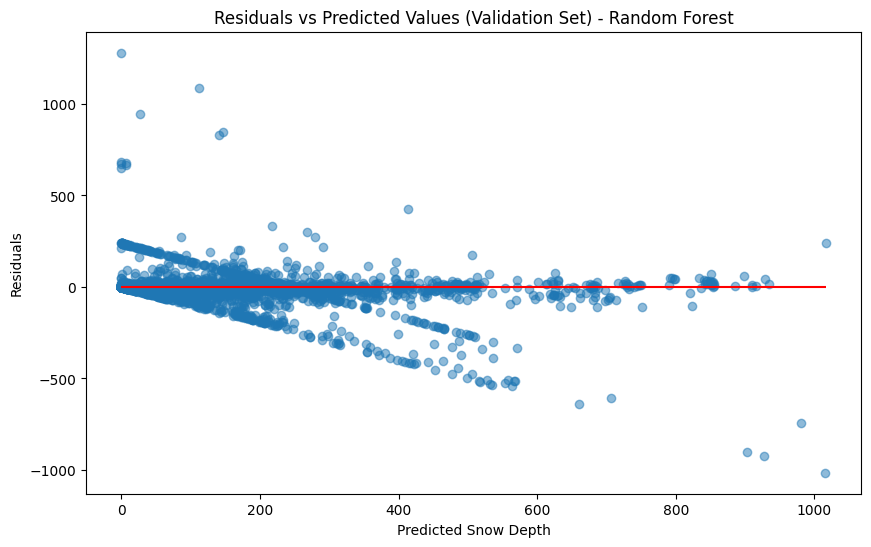

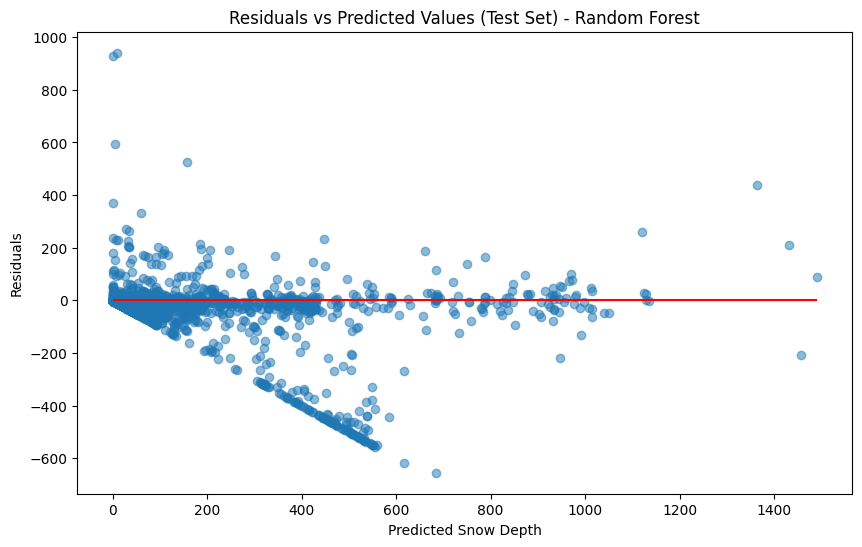

In [21]:
# Residuals on validation set
residuals_val = y_val - y_val_pred
plt.figure(figsize=(10,6))
plt.scatter(y_val_pred, residuals_val, alpha=0.5)
plt.hlines(y=0, xmin=y_val_pred.min(), xmax=y_val_pred.max(), colors='r')
plt.xlabel('Predicted Snow Depth')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Validation Set) - Random Forest')
plt.show()

# Residuals on test set
residuals_test = y_test - y_test_pred
plt.figure(figsize=(10,6))
plt.scatter(y_test_pred, residuals_test, alpha=0.5)
plt.hlines(y=0, xmin=y_test_pred.min(), xmax=y_test_pred.max(), colors='r')
plt.xlabel('Predicted Snow Depth')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Test Set) - Random Forest')
plt.show()